## yt Help Slack Channel Text Analysis

In [1]:
#%matplotlib notebook

In [213]:
import ktrain
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime
from itertools import chain
import emoji_data_python

In [214]:
#borrowed

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s|]' if not remove_digits else r'[^a-zA-z\s|]'
    text = re.sub(pattern, '', text)
    text = text.replace('`', "")
    return text

In [215]:
# in progress

def find_special_characters(text):
    pattern = re.findall(":$", text) 
    return pattern

In [216]:
s = "Sam :smile: is testing :frown_face:"

In [217]:
find_special_characters(s)

[':']

In [218]:
def topic_stop_words(word_list):
    clean_string = ""
    list_split = word_list.split()
    for w in list_split:
        if w not in stopwords:
            clean_string += w + " "
    return(clean_string)

In [219]:
def remove_stop_words(word_list):
    clean_list = []
    list_split = word_list.split()
    for w in list_split:
        if w not in stopwords:
            clean_list.append(w)
    return(clean_list)


In [220]:
def accummulate(two_lists):
    end_dict = {}
    for x in two_lists:
        if x not in end_dict:
            end_dict[x] = 1
        else:
            end_dict[x] = end_dict[x] + 1
    return(end_dict)

In [221]:
def get_code(words, start_symbol, end_symbol, pattern, anti_pattern='?'):
    code_block = ''
    if anti_pattern not in words:
        if pattern in words:
            code_block_start = words.find(start_symbol, 0, len(words))
            code_block_end = words.find(end_symbol, code_block_start+1, len(words))
            code_block = words[code_block_start+1:code_block_end]
           # print(code_block)
    return code_block

In [222]:
otherfile = open("stopwords.txt", "rt")

stopwords = otherfile.read()

In [223]:
user_id = []
user_text =[]
just_words = []
user_id_dict = {}
ts_id_dict = {}

for file in glob.iglob('yt-Slack-export-Mar-17-2015-Apr-1-2020/help/*.json'):
    one_file = open(file, 'r')
    json_file = json.load(one_file)
    
    for j in json_file:
            
        for i in j.keys():
            try:
                if i == 'ts':
                    text = j['text'].lower()
                    if j['ts'] not in ts_id_dict:
                        ts_id_dict[j['ts']] = [j['type'], j['user'], text]
                    if j['files'] != None:
                        files = j['files']
                        for f in files:
                            file_shared = f['filetype']
                            #print(file_shared)
                    ts_id_dict[j['ts']].append(file_shared)
            except:
                pass

            if i == 'text':
                one_word = j['text'].split(' ')
                just_words += one_word
                user_text.append(j['text'])
                

In [224]:
df_ts_id = pd.DataFrame.from_dict(ts_id_dict, orient='index', columns = ["type", "user", "text", "files"])

In [225]:
df_ts_id

type       user  \
1574339930.160000  message  UD9L1D44T   
1574344978.161000  message  U042FH0RB   
1574383719.162300  message  U046K2QNK   
1574398975.162800  message  U042FH0RB   
1574398987.163300  message  U042FH0RB   
...                    ...        ...   
1582851657.082100  message  U042FH0RB   
1582851666.082400  message  U042FH0RB   
1582863926.083400  message  UJEEUV7LH   
1529422577.000017  message  UBA7LU7UJ   
1565779103.115100  message  UME7T58A2   

                                                                text files  
1574339930.160000  hi ! i’m pretty sure it’s possible to define u...  None  
1574344978.161000  i don’t actually think there is a public api t...  None  
1574383719.162300  in `powderday` i'm trying to write code that w...  None  
1574398975.162800                that’ll break when yt-4.0 comes out  None  
1574398987.163300  maybe just check the first digit of the versio...  None  
...                                                              ...   ...  
1582851657.082100  i can probably provide a workaround if i have ...  None  
1582851666.082400                                     <@ujeeuv7lh> ^  None  
1582863926.083400  <@u042fh0rb> yeah let me see if i can reproduc...  None  
1529422577.000017                <@uba7lu7uj> has joined the channel  None  
1565779103.115100                <@ume7t58a2> has joined the channel  None  

[5898 rows x 4 columns]

In [226]:
df_ts_id['timestamp'] = [str(datetime.fromtimestamp(float(x)))for x in df_ts_id.index]

In [227]:
df_ts_id[['date', 'time']] = df_ts_id['timestamp'].str.split(expand = True)

In [228]:
df_ts_id['word_count'] = [len(x) for x in df_ts_id['text']]

In [229]:
df_ts_id['clean_text'] = [remove_special_characters(x) for x in df_ts_id['text']]

In [230]:
df_ts_id['cleaner_text'] = [remove_stop_words(x) for x in df_ts_id['clean_text']]

In [231]:
df_ts_id['topic_text'] = [topic_stop_words(x) for x in df_ts_id['clean_text']]

In [232]:
df_ts_id['year'] = [x[:4] for x in df_ts_id['date']]

In [233]:
df_ts_id['year-month'] = [x[:7] for x in df_ts_id['date']]

In [234]:
df_ts_id['code_block'] = [get_code(x, '```', '```', '```') for x in df_ts_id['text']]

In [235]:
df_ts_id['code_block'] = df_ts_id['code_block'].replace('', np.nan, regex=True)

In [236]:
df_ts_id['links'] = [get_code(x, '<', '>', 'http', '@') for x in df_ts_id['text']]

In [237]:
df_ts_id['links'] = df_ts_id['links'].replace('', np.nan, regex=True)

In [238]:
df_ts_id['emojis'] = [get_code(x, ':', ':', ':', 'http') for x in df_ts_id['text']]

In [239]:
df_ts_id['emojis'] = df_ts_id['emojis'].replace('', np.nan, regex=True)

In [240]:
df_ts_id

type       user  \
1574339930.160000  message  UD9L1D44T   
1574344978.161000  message  U042FH0RB   
1574383719.162300  message  U046K2QNK   
1574398975.162800  message  U042FH0RB   
1574398987.163300  message  U042FH0RB   
...                    ...        ...   
1582851657.082100  message  U042FH0RB   
1582851666.082400  message  U042FH0RB   
1582863926.083400  message  UJEEUV7LH   
1529422577.000017  message  UBA7LU7UJ   
1565779103.115100  message  UME7T58A2   

                                                                text files  \
1574339930.160000  hi ! i’m pretty sure it’s possible to define u...  None   
1574344978.161000  i don’t actually think there is a public api t...  None   
1574383719.162300  in `powderday` i'm trying to write code that w...  None   
1574398975.162800                that’ll break when yt-4.0 comes out  None   
1574398987.163300  maybe just check the first digit of the versio...  None   
...                                                              ...   ...   
1582851657.082100  i can probably provide a workaround if i have ...  None   
1582851666.082400                                     <@ujeeuv7lh> ^  None   
1582863926.083400  <@u042fh0rb> yeah let me see if i can reproduc...  None   
1529422577.000017                <@uba7lu7uj> has joined the channel  None   
1565779103.115100                <@ume7t58a2> has joined the channel  None   

                                    timestamp        date             time  \
1574339930.160000  2019-11-21 06:38:50.160000  2019-11-21  06:38:50.160000   
1574344978.161000  2019-11-21 08:02:58.161000  2019-11-21  08:02:58.161000   
1574383719.162300  2019-11-21 18:48:39.162300  2019-11-21  18:48:39.162300   
1574398975.162800  2019-11-21 23:02:55.162800  2019-11-21  23:02:55.162800   
1574398987.163300  2019-11-21 23:03:07.163300  2019-11-21  23:03:07.163300   
...                                       ...         ...              ...   
1582851657.082100  2020-02-27 19:00:57.082100  2020-02-27  19:00:57.082100   
1582851666.082400  2020-02-27 19:01:06.082400  2020-02-27  19:01:06.082400   
1582863926.083400  2020-02-27 22:25:26.083400  2020-02-27  22:25:26.083400   
1529422577.000017  2018-06-19 10:36:17.000017  2018-06-19  10:36:17.000017   
1565779103.115100  2019-08-14 05:38:23.115100  2019-08-14  05:38:23.115100   

                   word_count  \
1574339930.160000         151   
1574344978.161000         115   
1574383719.162300         294   
1574398975.162800          35   
1574398987.163300          55   
...                       ...   
1582851657.082100          66   
1582851666.082400          14   
1582863926.083400         126   
1529422577.000017          35   
1565779103.115100          35   

                                                          clean_text  \
1574339930.160000  hi  im pretty sure its possible to define unit...   
1574344978.161000  i dont actually think there is a public api to...   
1574383719.162300  in powderday im trying to write code that will...   
1574398975.162800                   thatll break when yt40 comes out   
1574398987.163300  maybe just check the first digit of the versio...   
...                                                              ...   
1582851657.082100  i can probably provide a workaround if i have ...   
1582851666.082400                                        ujeeuv7lh ^   
1582863926.083400  u042fh0rb yeah let me see if i can reproduce i...   
1529422577.000017                   uba7lu7uj has joined the channel   
1565779103.115100                   ume7t58a2 has joined the channel   

                                                        cleaner_text  \
1574339930.160000  [pretty, possible, define, units, equivalences...   
1574344978.161000  [actually, think, public, api, poke, around, c...   
1574383719.162300  [powderday, trying, write, code, automagically...   
1574398975.162800                       [thatll, break, yt40, comes]   
1574398987.163300      [maybe, ch

In [241]:
ktrain.text.preprocessor.detect_lang = ktrain.text.textutils.detect_lang
df = df_ts_id
texts = df['topic_text']
tm = ktrain.text.get_topic_model(texts, n_topics=None, n_features=10000)

n_topics automatically set to 54
lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [242]:
tm.print_topics()
tm.build(texts, threshold=0.25)

topic 0 | thing git nice fwiw master basically tomorrow repo bad day
topic 1 | server normally handle arrays entire dsr spent finder failed snapshot
topic 2 | script install condaforge test running pip problem conda fine run
topic 3 | httpsnbviewerjupyterorgurltridentprojectorgnotebookstrident_demesh_installipynb sunrise memory filter particle gas_tracer ramses frontend implemented computer
topic 4 | know function offhand values u042s6y2g interface recently bet unit moment
topic 5 | amr data simulation format information mpi trident ray files warning
topic 6 | deposit operation handles cic h_p1_fraction covering_grid automatically yt3 particle look
topic 7 | case matplotlib installed yts plotting path special copy dscoordinatesx_axis expected
topic 8 | issue density gas github particles cell include number cells open
topic 9 | think making easier remember said ago second order years weight_fieldnone
topic 10 | instance calls force refactor greater guess data scatter complicated plot
to

In [243]:
texts = tm.filter(texts)
df = tm.filter(df)

In [244]:
tm.visualize_documents(doc_topics=tm.get_doctopics())

reducing to 2 dimensions...[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1526 samples in 0.004s...
[t-SNE] Computed neighbors for 1526 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1526
[t-SNE] Computed conditional probabilities for sample 1526 / 1526
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.499306
[t-SNE] KL divergence after 1000 iterations: 0.445558
done.


Loading BokehJS ...

In [266]:
git_results = tm.search('git', case_sensitive=False)
mesh_results = tm.search('mesh', case_sensitive=False)
amr_results = tm.search('amr', case_sensitive=False)

In [267]:
threshold = .80
git_topic_ids = {doc[3] for doc in git_results if doc[2]>threshold}
mesh_topic_ids = {doc[3] for doc in mesh_results if doc[2]>threshold}
amr_topic_ids = {doc[3] for doc in amr_results if doc[2]>threshold}


In [268]:
t_topics = git_topic_ids.copy()
t_topics.update(mesh_topic_ids)
t_topics.update(amr_topic_ids)

In [269]:
tm.visualize_documents(doc_topics=tm.get_doctopics(t_topics))

reducing to 2 dimensions...[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1526 samples in 0.003s...
[t-SNE] Computed neighbors for 1526 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1526
[t-SNE] Computed conditional probabilities for sample 1526 / 1526
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.499306
[t-SNE] KL divergence after 1000 iterations: 0.445558
done.


Loading BokehJS ...

In [34]:
emojis_in_df = df_ts_id[df_ts_id['emojis'].notnull()]
emojis_in_df['emojis']

1574383719.162300                                          \n   blah``
1535486614.000100                                               (units
1535486793.000100                                slightly_smiling_face
1568659517.000300      how do i get the star formation rate _now_? ...
1539078336.000100     what should the argument of `yt.sliceplot.set...
                                           ...                        
1543356351.214600                                slightly_smiling_face
1543356712.215600                                                smile
1470343074.000003                                  getting help with y
1579616136.034900    \n```import yt\nimport numpy as np\n\nds = yt....
1582845692.078400     &lt;ufunc '? (vectorized)'&gt;` and `unit_ope...
Name: emojis, Length: 527, dtype: object

In [35]:
links_in_df = df_ts_id[df_ts_id['links'].notnull()]
links_in_df['links']

1574399098.164000    https://github.com/yt-project/yt/blob/master/s...
1535486275.000200    https://gist.github.com/cphyc/ea1f8217cfd7b04f...
1535487825.000100    https://github.com/yt-project/yt/blob/70403c8b...
1529516560.000400    https://github.com/yt-project/yt/blob/master/y...
1529517861.000514                        https://pastebin.com/tmffef1g
                                           ...                        
1564583364.075800    https://yt-project.org/doc/visualizing/manual_...
1553538469.138100    http://yt-project.org/doc/analyzing/analysis_m...
1553538859.140400      http://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/
1574108890.157600           https://github.com/yt-project/yt/pull/2358
1582850287.080200       http://yt-project.org/data|yt-project.org/data
Name: links, Length: 321, dtype: object

In [36]:
code_in_df = df_ts_id[df_ts_id['code_block'].notnull()]
code_in_df['code_block']

1535486614.000100    ``\n&gt; sp['gas_tracer', 'cell_density']\n\nd...
1529519395.000412    ``\ndiff --git a/yt/fields/field_detector.py b...
1553624983.150900    ``\nad.set_field_parameter('rotation_vectors',...
1534107369.000030    ``file "../../../pelecode/pele_make_movie_stri...
1563994530.015300    ``\nds = yt.load('out.e')\nprint(ds.field_list)\n
                                           ...                        
1529080978.000581    ``\nextensions = ['sphinx.ext.autodoc', 'sphin...
1537971427.000100    ``\nin [1]: ds.coordinates.x_axis['z'] = 1\n\n...
1536257154.000100    ``\nplot = yt.sliceplot(ds, 'z', ['density', '...
1579616136.034900    ``import yt\nimport numpy as np\n\nds = yt.loa...
1571869601.050100    ``\nds.coordinates.x_axis[1] = 0\nds.coordinat...
Name: code_block, Length: 178, dtype: object

In [37]:
files_in_df = df_ts_id[df_ts_id['files'].notnull()]
files_in_df['files']

1535486275.000100    python
1535487390.000100    binary
1553637365.185500       png
1553637396.185900       png
1534107187.000045    python
                      ...  
1541653143.129500      text
1583886793.164600       png
1547517036.155900      text
1576170147.300800    binary
1583507899.152200       png
Name: files, Length: 121, dtype: object

In [38]:
df_ts_id.describe()

word_count
count  5898.000000
mean    107.604781
std     210.659686
min       0.000000
25%      35.000000
50%      63.000000
75%     113.000000
max    5412.000000

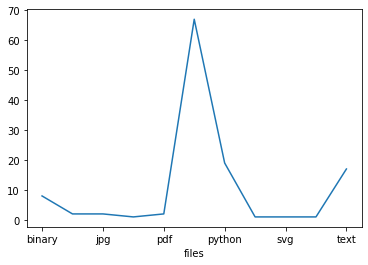

In [39]:
df_ts_id.groupby('files')['text'].count().plot()

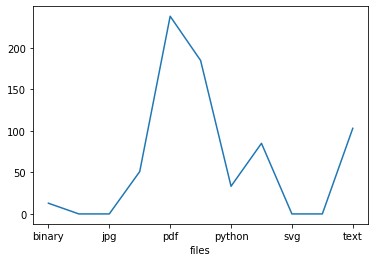

In [40]:
df_ts_id.groupby('files')['word_count'].mean().plot()

Text(0, 0.5, 'Count of Messages')

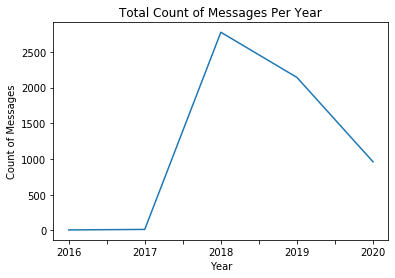

In [41]:
messages_per_date_ts = df_ts_id.groupby('year')['text'].count().plot()
plt.title("Total Count of Messages Per Year")
plt.xlabel("Year")
plt.ylabel("Count of Messages")

Text(0, 0.5, 'Count of Messages')

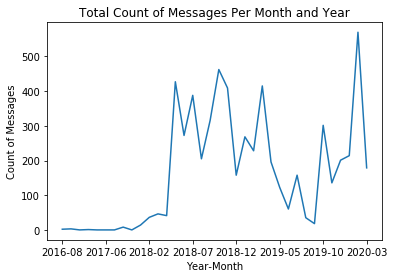

In [42]:
messages_per_date_ts = df_ts_id.groupby('year-month')['text'].count().plot()
plt.title("Total Count of Messages Per Month and Year")
plt.xlabel("Year-Month")
plt.ylabel("Count of Messages")

Text(0, 0.5, 'Average Number of Words per Message')

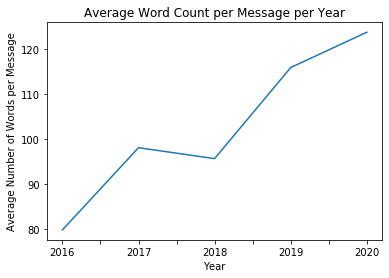

In [43]:
messages_per_date_ts = df_ts_id.groupby('year')['word_count'].mean().plot()
plt.title("Average Word Count per Message per Year")
plt.xlabel("Year")
plt.ylabel("Average Number of Words per Message")

Text(0, 0.5, 'Average Word Count')

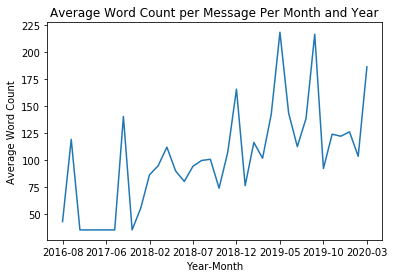

In [44]:
messages_per_date_ts = df_ts_id.groupby('year-month')['word_count'].mean().plot()
plt.title("Average Word Count per Message Per Month and Year")
plt.xlabel("Year-Month")
plt.ylabel("Average Word Count")

Text(0.5, 1.0, 'Distribution of Word Count per Message')

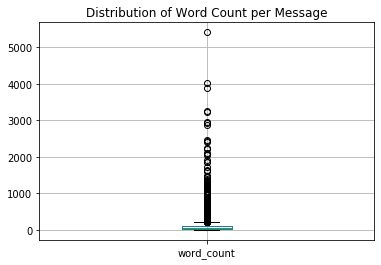

In [45]:
df_ts_id.boxplot(column='word_count')
plt.title("Distribution of Word Count per Message")

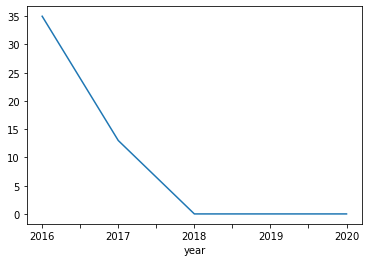

In [46]:
df_ts_id.groupby('year')['word_count'].min().plot()

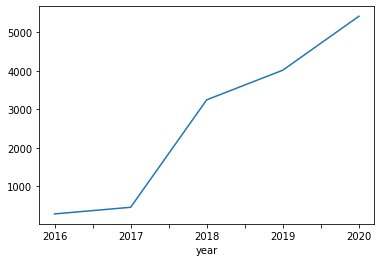

In [47]:
df_ts_id.groupby('year')['word_count'].max().plot()

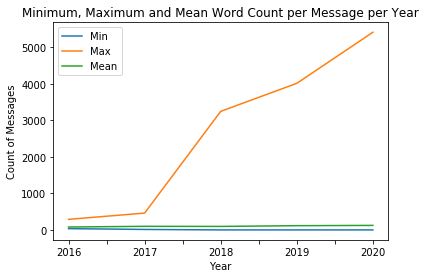

In [48]:
df_ts_id.groupby('year')['word_count'].min().plot()
df_ts_id.groupby('year')['word_count'].max().plot()
df_ts_id.groupby('year')['word_count'].mean().plot()
plt.title("Minimum, Maximum and Mean Word Count per Message per Year")
plt.xlabel("Year")
plt.ylabel("Count of Messages")
plt.legend(['Min', 'Max', 'Mean'])

In [49]:
df_ts_id.groupby(['code_block', 'links', 'files'])['word_count'].plot()

Series([], Name: word_count, dtype: float64)

Text(0, 0.5, 'Count of Messages')

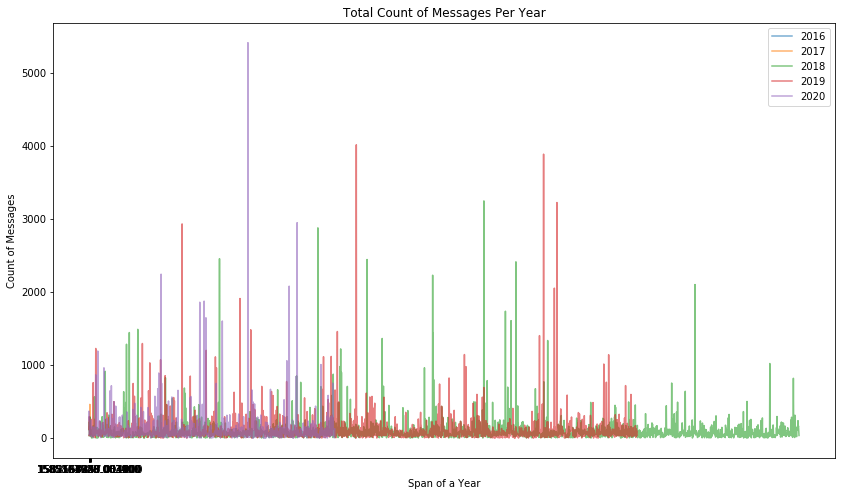

In [50]:
plt.figure(figsize=(14, 8))
df_ts_id.groupby('year')['word_count'].plot(alpha=0.6)
plt.legend()
plt.title("Total Count of Messages Per Year")
plt.xlabel("Span of a Year")
plt.ylabel("Count of Messages")


In [51]:
print(len(df_ts_id[df_ts_id['code_block'].notnull()]), "code blocks, which is % of code blocks", (len(df_ts_id[df_ts_id['code_block'].notnull()])/len(df_ts_id)*100))
print()
print(len(df_ts_id[df_ts_id['links'].notnull()]), "links, which is % of links", (len(df_ts_id[df_ts_id['links'].notnull()])/len(df_ts_id)*100))
print()
print(len(df_ts_id[df_ts_id['files'].notnull()]),  "files, which is % of files", (len(df_ts_id[df_ts_id['files'].notnull()])/len(df_ts_id)*100))

178 code blocks, which is % of code blocks 3.017972193964056

321 links, which is % of links 5.442522889114954

121 files, which is % of files 2.0515428958969144


In [52]:
just_words_sort = {}

for x in df_ts_id['cleaner_text']:
    #print(x)
    for y in x:
       # print(y)
        if y not in just_words_sort:
            just_words_sort[y] = 1
        else:
            just_words_sort[y] = just_words_sort[y] + 1
    

In [53]:
sorted_word_list = list(just_words_sort.items())

In [54]:
def by_value(pair):
    return pair[1]

sorted_word_list.sort(key = by_value, reverse= True)

count = 0

d_sorted = {}

for pair in sorted_word_list:
    count += 1
    if count <= 25:
        d_sorted[pair[0]] = pair[1]
    
print(d_sorted.items())

dict_items([('yt', 746), ('data', 476), ('field', 395), ('think', 360), ('thanks', 298), ('one', 266), ('using', 265), ('file', 247), ('channel', 235), ('make', 233), ('see', 228), ('issue', 224), ('joined', 212), ('know', 209), ('work', 209), ('something', 196), ('code', 195), ('dataset', 192), ('fields', 189), ('try', 185), ('plot', 175), ('particle', 166), ('slightly_smiling_face', 154), ('doing', 151), ('trying', 149)])


Text(0.5, 1.0, 'Top words in yt Help Slack Channel')

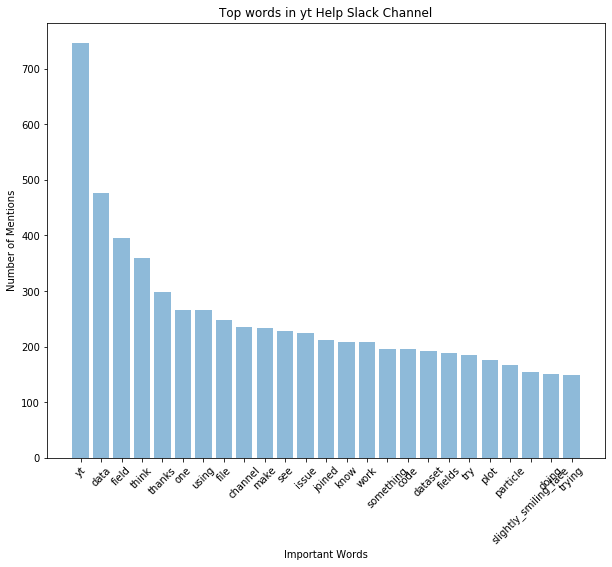

In [55]:
plt.figure(figsize=(10, 8))
plt.bar(d_sorted.keys(), d_sorted.values(), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Important Words')
plt.ylabel('Number of Mentions')
plt.title("Top words in yt Help Slack Channel")


In [56]:
date_and_words = df_ts_id[['date', 'cleaner_text']]

In [57]:
date_and_words.set_index('date')

cleaner_text
date                                                         
2019-11-21  [pretty, possible, define, units, equivalences...
2019-11-21  [actually, think, public, api, poke, around, c...
2019-11-21  [powderday, trying, write, code, automagically...
2019-11-21                       [thatll, break, yt40, comes]
2019-11-21      [maybe, check, first, digit, version, string]
...                                                       ...
2020-02-27        [probably, provide, workaround, code, look]
2020-02-27                                     [ujeeuv7lh, ^]
2020-02-27  [u042fh0rb, let, see, reproduce, one, test, da...
2018-06-19                       [uba7lu7uj, joined, channel]
2019-08-14                       [ume7t58a2, joined, channel]

[5898 rows x 1 columns]

In [58]:
def cleaning(two_lists, new_dict):
    for x in two_lists:
        if x not in new_dict:
            new_dict[x] = 1
        else:
            new_dict[x] = new_dict[x]+1
                
    return new_dict
      

In [59]:

def cat_count_words(user_cat):
    cat_list = []
    if user_cat in categories.keys():
        cat_filter = categories[user_cat]
        for i,v in just_words_sort.items():
            if i in cat_filter:
                cat_list.append([i,v])
    return cat_list

In [60]:
categories = {'versioning' : ['git', 'conda', 'version', 'issue', 'condaforge', 
              'pip', 'fork', 'repository', 'master', 'branch',
              'homebrew', 'path', 'github', 'repo', 'request', 
             'pull', 'push', 'clone'],
              
              'frontends' : ['ahf', 'amrvac', 'art', 'artio', 'athena', 'athena_pop', 
             'boxlib', 'chombo', 'eagle', 'enzo', 'enzo_p', 'exodus_ii', 
             'fits', 'flash', 'gadget', 'gadget_fof', 'gamer', 'gdf', 
             'gizmo', 'halo_catalog', 'http_stream', 'moab', 'open_pmd', 
             'owls', 'owls_subfind', 'ramses',
             'rockstar', 'sdf', 'sph', 'stream', 'tipsy', 'ytdata', 'frontend',
            'frontends'],
              
            'visualization' : ['sliceplot', 'slice', 'plot', 
            'projection', 'projectionplot', 'phase', 'profile', 
                'phaseplot','2d', '3d', 'color', 'colormap', 
            'plotting', 'image', 'images', 'resolution',
            'line', 'lineplot', 'axis', 'streamlines', 'png'],
             'loading_data' : ['load', 'data', 'file', 'zip', 'hdf5', 'json', 
                'notebook', 'dataset', 'files', 'txt', 'folder', 
                'directory', 'loading', 'loads', 'unzip', 'tar'
               ],
              
             'installation' : ['install', 'release', 'installing', 'installed',
               'update', 'enivronment', 'dependency', 'dependencies',
               'requirements', 'machine', 'windows', 'mac'],
              
             'volume_rendering' : ['volume', 'render', 'volumerender', 'volumerendering', 'rendering', 'rotate', 'camera', 'lens', 
                   'blend', 'blender', 'scene', 'zbuffer', 'off', 'axis'
                   'offaxis', 'shader', 'transfer function'],
              
              'volume_rendering': ['volume', 'render', 'volumerender', 'volumerendering', 'rendering', 'rotate', 'camera', 'lens', 
                   'blend', 'blender', 'scene', 'zbuffer', 'off', 'axis'
                   'offaxis', 'shader', 'transfer function'],
             
              'analysis' : ['analysis', 'average', 'mean', 'sum', 'median', 'max', 'maximum', 'min', 'clump','minimum', 
            'absorption spectrum', 'cosmological observation', 'halo', 'halos', 'halofinder',
           'halo mass function', 'level sets', 'particle trajectories', 'photon simulator', 'ppv cube',
           'radmc 3d export', 'spectral integrator', 'star analysis', 'sunrise export', 'sunyaev_zeldovich', 'two point functions'],
              
            'units' : ['unit', 'units', 'unyt', 'cm', 'mm', 'cgs', 'km', 
         'dimensions', 'equivalencies', 'symbols','symbol',
         'conversions'],
              
          'data_structures' : ['array', 'container', 'object', 
                   'time series', 'unions', 'mesh', 'grid', 
                   'unstructured', 'grid patch', 'uniform', 'structured',
                  'region', 'cell', 'cells', 'sphere', 'cylinder', 
                   'disk', 'objects', 'containers', 'octree', 'ytarray', 
                   'ytcontainer', 'string', 'list', 'dictionary', 'tuple'],
              
           'community' : ['channel', 'worksop', 'tutorial', 'meeting', 'resources',
            'website', 'twitter', 'opensource', 'docs', 'documentation',
             'presenation', 'paper', 'poster', 'joined', 'conduct'],
            
            'coordinates' : ['spherical', 'cartesian', 'azimuthal', 'coordinates'],
              
            
            'other_libraries' : ['numpy', 'matplotlib', 'cartopy']
    
              
              
             }

In [61]:
category_count = {}

In [62]:
version_total = 0
for i,v in just_words_sort.items():
    if i in categories['versioning']:
        print(i, v)
        version_total += v
print(version_total)

category_count['versioning'] = version_total 

version 123
issue 224
pull 42
request 21
repo 17
git 44
clone 11
github 42
condaforge 89
conda 46
path 25
pip 69
branch 34
push 4
repository 4
fork 9
master 27
homebrew 1
832


In [63]:
frontends_total = 0
for i, v in just_words_sort.items():
    if i in categories['frontends']:
        print(i, v)
        frontends_total +=v
print(frontends_total)
category_count['frontends'] = frontends_total 

frontend 37
rockstar 31
ramses 45
athena 7
fits 5
sph 54
gizmo 26
boxlib 2
enzo 26
gadget 21
artio 1
tipsy 3
amrvac 6
art 1
ahf 17
frontends 5
ytdata 4
stream 10
eagle 3
flash 4
halo_catalog 1
309


In [64]:
viz_total = 0
for i, v in just_words_sort.items():
    if i in categories['visualization']:
        print(i, v)
        viz_total += v
print(viz_total)
category_count['viz'] = viz_total 

2d 38
line 147
3d 57
image 92
png 7
colormap 14
phase 18
plot 175
profile 70
axis 41
plotting 30
slice 50
color 26
phaseplot 13
resolution 48
projection 72
projectionplot 21
sliceplot 23
streamlines 16
images 15
lineplot 1
974


In [65]:
loading_data_total = 0
for i,v in just_words_sort.items():
    if i in categories['loading_data']:
        print(i, v)
        loading_data_total += v
print(loading_data_total)
category_count['loading_data'] = loading_data_total 

data 476
dataset 192
directory 19
files 58
file 247
loading 27
load 76
notebook 28
folder 9
hdf5 10
tar 3
loads 2
1147


In [66]:
installation_total = 0
for i,v in just_words_sort.items():
    if i in categories['installation']:
        print(i, v)
        installation_total += v
print(installation_total)

category_count['installation'] = installation_total

installing 55
install 122
dependency 2
mac 11
installed 39
machine 15
release 15
dependencies 4
update 34
windows 3
requirements 3
303


In [67]:
volume_total = 0
for i,v in just_words_sort.items():
    if i in categories['volume_rendering']:
        print(i, v)
        volume_total += v
print(volume_total)

category_count['volume_rendering'] = volume_total 

volume 54
rendering 43
rotate 9
off 34
render 7
volumerender 1
scene 3
camera 1
lens 4
blender 1
157


In [68]:
analysis_total = 0
for i,v in just_words_sort.items():
    if i in categories['analysis']:
        print(i, v)
        analysis_total += v
print(analysis_total)

category_count['analysis'] = analysis_total 

halo 102
mean 60
halos 40
analysis 22
minimum 3
maximum 4
average 18
min 12
max 19
clump 7
sum 11
298


In [69]:
units_total = 0
for i,v in just_words_sort.items():
    if i in categories['units']:
        print(i, v)
        units_total += v
print(units_total)

category_count['units'] = units_total 

units 92
unit 43
cm 13
cgs 4
dimensions 5
unyt 11
symbol 3
conversions 1
symbols 2
174


In [70]:
data_structures_total = 0
for i,v in just_words_sort.items():
    if i in categories['data_structures']:
        print(i, v)
        data_structures_total += v
print(data_structures_total)

category_count['data_structures'] = data_structures_total

string 11
cell 38
grid 98
cells 27
array 55
sphere 52
object 126
objects 32
unstructured 9
mesh 42
tuple 8
dictionary 12
ytarray 9
list 48
region 52
disk 27
structured 4
octree 38
uniform 14
containers 2
container 6
unions 2
cylinder 1
713


In [71]:
community_total = 0
for i,v in just_words_sort.items():
    if i in categories['community']:
        print(i, v)
        community_total += v
print(community_total)

category_count['community'] = community_total

joined 212
channel 235
documentation 25
paper 18
docs 37
tutorial 10
website 8
poster 1
meeting 3
resources 4
553


In [72]:
coordinates_total = 0
for i,v in just_words_sort.items():
    if i in categories['coordinates']:
        print(i, v)
        coordinates_total += v
print(coordinates_total)

category_count['coordinates'] = coordinates_total

cartesian 16
coordinates 32
spherical 11
azimuthal 2
61


In [73]:
other_libraries_total = 0
for i,v in just_words_sort.items():
    if i in categories['other_libraries']:
        print(i, v)
        other_libraries_total += v
print(other_libraries_total)

category_count['other_libraries'] = other_libraries_total

numpy 34
matplotlib 56
cartopy 5
95


In [74]:
sorted_category_list = list(category_count.items())

sorted_category_list.sort(key = by_value, reverse= True)

category_sorted = {}

for pair in sorted_category_list:
    category_sorted[pair[0]] = pair[1]
    
print(category_sorted.items())

dict_items([('loading_data', 1147), ('viz', 974), ('versioning', 832), ('data_structures', 713), ('community', 553), ('frontends', 309), ('installation', 303), ('analysis', 298), ('units', 174), ('volume_rendering', 157), ('other_libraries', 95), ('coordinates', 61)])


In [75]:
def pick_simple():
    # simple picking, lines, rectangles and text
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.set_title('click on points, rectangles or text', picker=True)
    ax1.set_ylabel('ylabel', picker=True, bbox=dict(facecolor='red'))
    line, = ax1.plot(category_sorted.keys(), category_sorted.values())  # 5 points tolerance

    # pick the rectangle
    bars = ax2.bar(range(10), rand(10), picker=True)
    for label in ax2.get_xticklabels():  # make the xtick labels pickable
        label.set_picker(True)

    def onpick1(event):
        if isinstance(event.artist, Line2D):
            thisline = event.artist
            xdata = thisline.get_xdata()
            ydata = thisline.get_ydata()
            ind = event.ind
            print('onpick1 line:', np.column_stack([xdata[ind], ydata[ind]]))
        elif isinstance(event.artist, Rectangle):
            patch = event.artist
            print('onpick1 patch:', patch.get_path())

    fig.canvas.mpl_connect('pick_event', onpick1)

Text(0.5, 0, 'Categories')

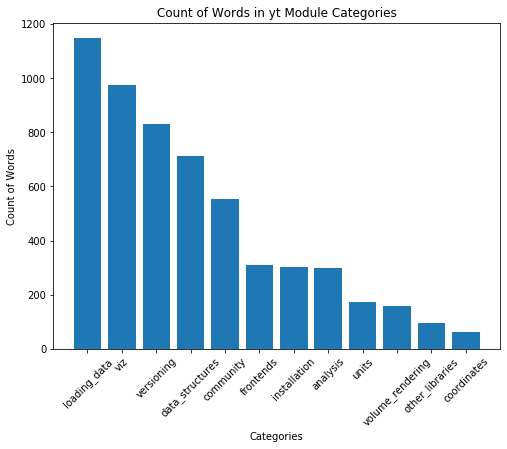

In [76]:
plt.figure(figsize=(8, 6))
plt.bar(category_sorted.keys(), category_sorted.values())
plt.xticks(rotation=45)
plt.title('Count of Words in yt Module Categories')
plt.ylabel('Count of Words')
plt.xlabel('Categories')

In [77]:
print(category_count.items())

dict_items([('versioning', 832), ('frontends', 309), ('viz', 974), ('loading_data', 1147), ('installation', 303), ('volume_rendering', 157), ('analysis', 298), ('units', 174), ('data_structures', 713), ('community', 553), ('coordinates', 61), ('other_libraries', 95)])


Enter a category: units
['units', 92]
['unit', 43]
['cm', 13]
['unyt', 11]
['dimensions', 5]
['cgs', 4]
['symbol', 3]
['symbols', 2]
['conversions', 1]


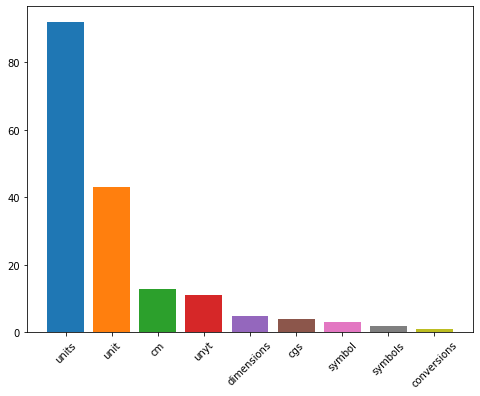

In [78]:
user_category = input("Enter a category: ")

t = cat_count_words(user_category)

plt.figure(figsize=(8, 6))

t_sorted = t.sort(key=lambda x: x[1], reverse = True)

for x in t:
    print(x)
    plt.bar(x[0], x[1])
    plt.xticks(rotation=45)

In [81]:
df_ts_id['words_per_ts'] = df_ts_id['cleaner_text'].map(lambda i: accummulate(i))
df_ts_id

type       user  \
1574339930.160000  message  UD9L1D44T   
1574344978.161000  message  U042FH0RB   
1574383719.162300  message  U046K2QNK   
1574398975.162800  message  U042FH0RB   
1574398987.163300  message  U042FH0RB   
...                    ...        ...   
1582851657.082100  message  U042FH0RB   
1582851666.082400  message  U042FH0RB   
1582863926.083400  message  UJEEUV7LH   
1529422577.000017  message  UBA7LU7UJ   
1565779103.115100  message  UME7T58A2   

                                                                text files  \
1574339930.160000  hi ! i’m pretty sure it’s possible to define u...  None   
1574344978.161000  i don’t actually think there is a public api t...  None   
1574383719.162300  in `powderday` i'm trying to write code that w...  None   
1574398975.162800                that’ll break when yt-4.0 comes out  None   
1574398987.163300  maybe just check the first digit of the versio...  None   
...                                                              ...   ...   
1582851657.082100  i can probably provide a workaround if i have ...  None   
1582851666.082400                                     <@ujeeuv7lh> ^  None   
1582863926.083400  <@u042fh0rb> yeah let me see if i can reproduc...  None   
1529422577.000017                <@uba7lu7uj> has joined the channel  None   
1565779103.115100                <@ume7t58a2> has joined the channel  None   

                                    timestamp        date             time  \
1574339930.160000  2019-11-21 06:38:50.160000  2019-11-21  06:38:50.160000   
1574344978.161000  2019-11-21 08:02:58.161000  2019-11-21  08:02:58.161000   
1574383719.162300  2019-11-21 18:48:39.162300  2019-11-21  18:48:39.162300   
1574398975.162800  2019-11-21 23:02:55.162800  2019-11-21  23:02:55.162800   
1574398987.163300  2019-11-21 23:03:07.163300  2019-11-21  23:03:07.163300   
...                                       ...         ...              ...   
1582851657.082100  2020-02-27 19:00:57.082100  2020-02-27  19:00:57.082100   
1582851666.082400  2020-02-27 19:01:06.082400  2020-02-27  19:01:06.082400   
1582863926.083400  2020-02-27 22:25:26.083400  2020-02-27  22:25:26.083400   
1529422577.000017  2018-06-19 10:36:17.000017  2018-06-19  10:36:17.000017   
1565779103.115100  2019-08-14 05:38:23.115100  2019-08-14  05:38:23.115100   

                   word_count  \
1574339930.160000         151   
1574344978.161000         115   
1574383719.162300         294   
1574398975.162800          35   
1574398987.163300          55   
...                       ...   
1582851657.082100          66   
1582851666.082400          14   
1582863926.083400         126   
1529422577.000017          35   
1565779103.115100          35   

                                                          clean_text  \
1574339930.160000  hi  im pretty sure its possible to define unit...   
1574344978.161000  i dont actually think there is a public api to...   
1574383719.162300  in powderday im trying to write code that will...   
1574398975.162800                   thatll break when yt40 comes out   
1574398987.163300  maybe just check the first digit of the versio...   
...                                                              ...   
1582851657.082100  i can probably provide a workaround if i have ...   
1582851666.082400                                        ujeeuv7lh ^   
1582863926.083400  u042fh0rb yeah let me see if i can reproduce i...   
1529422577.000017                   uba7lu7uj has joined the channel   
1565779103.115100                   ume7t58a2 has joined the channel   

                                                        cleaner_text  \
1574339930.160000  [pretty, possible, define, units, equivalences...   
1574344978.161000  [actually, think, public, api, poke, around, c...   
1574383719.162300  [powderday, trying, write, code, automagically...   
1574398975.162800                       [thatll, break, yt40, comes]   
1574398987.163300      [maybe, ch

In [82]:
list(df_ts_id['words_per_ts'])

[{'pretty': 1,
  'possible': 1,
  'define': 1,
  'units': 1,
  'equivalences': 1,
  'userend': 1,
  'cant': 1,
  'find': 1,
  'back': 1,
  'done': 1,
  'cookbook': 1,
  'little': 1,
  'help': 1},
 {'actually': 1,
  'think': 1,
  'public': 1,
  'api': 1,
  'poke': 1,
  'around': 1,
  'code': 1,
  'figure': 1},
 {'powderday': 1,
  'trying': 1,
  'write': 1,
  'code': 2,
  'automagically': 1,
  'check': 2,
  'yt': 1,
  'version': 1,
  'deal': 1,
  'octrees': 1,
  'accordingly': 1,
  'reasonable': 1,
  'better': 1,
  'discern': 1,
  '3x': 1,
  '4x': 1,
  'yt__version__': 1,
  '40dev0': 1,
  'blah': 1},
 {'thatll': 1, 'break': 1, 'yt40': 1, 'comes': 1},
 {'maybe': 1, 'check': 1, 'first': 1, 'digit': 1, 'version': 1, 'string': 1},
 {'yt': 1, 'internally': 1, 'version': 1, 'checks': 1},
 {'httpsgithubcomytprojectytblobmastersetuppyl311': 1},
 {'less': 1, 'than': 2, 'greater': 1, 'comparisons': 1},
 {'id': 1,
  'check': 1,
  'make': 1,
  'looseversion': 1,
  'thing': 1,
  'dev0': 1,
  'version